## 4.4 Decentralized SVRG with Exact Diffusion

### 4.4.1 Problem and decentralized stochastic algorithms

Consider the optimization problem:

$$\min_{x \in \mathbb{R}^d} \quad f(x) = \frac{1}{n}\sum_{i=1}^n [f_i(x) = \mathbb{E}_{\xi_i \sim D_i}\{F(x,\xi_i)\}]$$

where $f_i(x)$ is local to node $i$, and random variable $\xi_i$ denotes the local data that follows distribution $D_i$. Each node $i$ can locally evaluate stochastic gradient $\nabla F(x;\xi_i)$ (not the real gradient $\nabla f_i(x)$); it must communicate to access information from other nodes.

In Section 3.6, we discussed one widely-used approach - ATC-DSGD to solve the above problem. Given the network topology and the weight matrix, the ATC-DSGD will update as follows:

\begin{align}
x_i^{(k+1)} =  \sum_{j=1}^n w_{ij} \Big(x_j^{(k)} - \alpha \nabla F(x_j^{(k)};\xi_j^{(k)}) \Big), \quad  i=1,\cdots,n.
\end{align}

where $\xi_i^{(k)}$ is a realization of the random variable $\xi_i$ at iteration $k$. Furthermore, it is established in Section 3.6 that under smoothness and strongly-convex assumptions, ATC-DSGD suffers from a limiting bias as follows:

\begin{align}\label{dsgd-convergence}
\lim_{k\to \infty}\frac{1}{n}\sum_{i=1}^n \mathbb{E}\|x_i^{(k)} - x^\star\|^2 = O\Big(\underbrace{\frac{\alpha \sigma^2}{n} + \frac{\rho^2 \alpha^2 \sigma^2}{1-\rho}}_{\rm sto.\ bias} + \underbrace{\frac{\rho^2 \alpha^2 b^2}{(1-\rho)^2}}_{\rm inconsis.\ bias} \Big). \hspace{1cm} \mbox{(ATC-DSGD-Limiting-Bias)}
\end{align}

It is observed that ATC-DSGD suffers from two sources of bias:

- A stochastic limiting bias caused by the stochastic gradient noise $\sigma^2$;

- An inconsistency bias caused by the data heterogeneity $b^2 = \frac{1}{n}\sum_{i=1}^n\|\nabla f_i(x^\star)\|^2$

This motivates us that, to correct the limiting bias, we have to design algorithms that can remove both the stochastic  bias and inconsistency bias. In Section 4.2, we have discussed that SVRG can remove the stochastic bias when the problem is in the finite-sum form. In Section 4.3, we have discussed that Exact-diffusion can remove the inconsistency bias. A natural idea is to integrate SVRG to Exact-diffusion so that the new algorithm can converge **exactly** to the global solution $x^\star$ without any limiting bias.

### 4.4.2 Exact Diffusion with SVRG 

In this section we disscuss the new algorithm. First, we assume each local $f_i(x) = \mathbb{E}_{\xi_i \sim D_i}\{F(x,\xi_i)\} = \frac{1}{M}\sum_{m=1}^M F_i(x; \xi_{m,i})$. In other words, we assume each $f_i(x)$ is in a **finite-sum** form. The Diffusion-SVRG algorithm is shown as follows. Each node $i$ will run the following algorithm in a parallel manner:

> \begin{align}
& \mbox{For $s = 1,2,\cdots$}\\
& \hspace{5mm} \tilde{x}_i = \tilde{x}_{i,s-1} \\
& \hspace{5mm} \tilde{\mu}_i = \frac{1}{M}\sum_{m=1}^M \nabla F(\tilde{x}_i, \xi_{m,i}) \\
& \hspace{5mm} x_{i}^0 = \tilde{x}_i \\
& \hspace{5mm} \mbox{For $k = 1,2,\cdots,K$}\\
& \hspace{15mm}\mbox{Randomly pick $m_{k} \in \{1,\cdots, M\}$ and compute the stochastic gradient as}\\ 
& \hspace{15mm}g^k_{i} = \nabla F(x_i^{k-1};\xi_{m_k,i}) - \nabla F(\tilde{x}_i;\xi_{m_k,i}) + \tilde{\mu}_i \\
& \hspace{15mm}\mbox{Update local variables $x_i$ as follows} \\
& \hspace{15mm}\psi_i^{k} = x_i^{k} - \alpha \nabla g^k_{i}  \\
& \hspace{15mm}\phi_i^{k} = \psi_i^{k} + x_i^{k} - \psi_i^{k-1} \\
& \hspace{15mm}x_i^{k+1} = \sum_{j=1}^n \bar{w}_{ij} \phi_j^{k} \\
& \hspace{5mm} \mbox{Set $\tilde{x}_{i,s} = x^K_i$}
\end{align}

When each $f_i(x)$ is smooth and strongly convex, and the gradient noise is unbiased and bounded, one can show the above Diffusion-SVRG algorithm can converge to the global solution $x^\star$ in a linear rate.

### 4.4.3 An example: least-square problem

In this section, we will show a demo on how to solve a decentralized least-square problem with decentralized SVRG with Exact Diffusion. Suppose $n$ computing nodes collaborate to solve the following problem:

$$\min_x \quad \frac{1}{n}\sum_{i=1}^n \|A_i x - b_i\|^2$$

where $\{A_i, b_i\}$ are local data held in node $i$.


#### 4.4.3.1 Set up Environment

In [15]:
import ipyparallel as ipp

rc = ipp.Client(profile="bluefog")
dview = rc[:]  # A DirectView of all engines
dview.block = True

In [16]:
%%px
import numpy as np
import bluefog.torch as bf
import torch
from bluefog.common import topology_util
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

bf.init()

#### 4.3.4.2 Generate local data $A_i$ and $b_i$

In [17]:
%%px


def generate_data(m, n):

    A = torch.randn(m, n).to(torch.double)
    x_o = torch.randn(n, 1).to(torch.double)
    ns = 0.1 * torch.randn(m, 1).to(torch.double)
    b = A.mm(x_o) + ns

    return A, b

In [18]:
%%px


def distributed_grad_descent(A, b, maxite=5000, alpha=1e-1):

    x_opt = torch.zeros(n, 1, dtype=torch.double)

    for _ in range(maxite):
        # calculate local gradient
        grad_local = A.t().mm(A.mm(x_opt) - b)

        # global gradient
        grad = bf.allreduce(grad_local, name="gradient")

        # distributed gradient descent
        x_opt = x_opt - alpha * grad

    grad_local = A.t().mm(A.mm(x_opt) - b)
    grad = bf.allreduce(grad_local, name="gradient")  # global gradient

    # evaluate the convergence of distributed gradient descent
    # the norm of global gradient is expected to 0 (optimality condition)
    global_grad_norm = torch.norm(grad, p=2)
    if bf.rank() == 0:
        print(
            "[Distributed Grad Descent] Rank {}: global gradient norm: {}".format(
                bf.rank(), global_grad_norm
            )
        )

    return x_opt

In [23]:
%%px

m, n = 500, 10
A, b = generate_data(m, n)
x_opt = distributed_grad_descent(A, b, maxite=1000, alpha=1e-4)

[stdout:0] [Distributed Grad Descent] Rank 0: global gradient norm: 6.941169754339275e-13


#### 4.3.4.3 One step of SVRG with Exact Diffusion

In [24]:
%%px

def SVRG_exact_diffusion_one_step(x, A, b, pre_psi, alpha=1e-2):
    m = A.size()[0]
    x_0 = x.clone()
    grad_0 = A.t().mm(A.mm(x_0) - b)/m # Precompute the full gradient of the step
    for _ in range(m):
        # Select a random sample
        i = torch.randint(m,(1,)).item()
        sample = A[i:i+1]
        grad_est_i =  sample.t()*(sample.mm(x)-b[i])
        grad_est_0 =   sample.t()*(sample.mm(x_0)-b[i])
        grad_est = grad_est_i - grad_est_0 + grad_0
        psi = x-alpha*grad_est
        phi = psi + x - pre_psi
        x = bf.neighbor_allreduce(phi)
        pre_psi = psi.clone()http://localhost:4000/notebooks/Section%204/Sec-4.4-Decentralized-SVRG-with-exact-diffusion.ipynb#
    return x, psi

In [34]:
%%px

# Set topology as ring topology.
G = topology_util.RingGraph(bf.size())
bf.set_topology(G)

max_iter = 300

alpha = 5e-4

x = torch.zeros(n, 1, dtype=torch.double)  # Initialize x for exact diffusion
psi = x
rel_error = torch.zeros((max_iter, 1))

for ite in range(max_iter):
    if ite % 10 == 0:
        if bf.rank() == 0:
            print("Progress {}/{}".format(ite, max_iter))
    x, psi = SVRG_exact_diffusion_one_step(x, A, b, psi, alpha=alpha)
    rel_error[ite] = torch.norm(x - x_opt, p=2) / torch.norm(x_opt, p=2)

[stdout:0] 
Progress 0/300
Progress 10/300
Progress 20/300
Progress 30/300
Progress 40/300
Progress 50/300
Progress 60/300
Progress 70/300
Progress 80/300
Progress 90/300
Progress 100/300
Progress 110/300
Progress 120/300
Progress 130/300
Progress 140/300
Progress 150/300
Progress 160/300
Progress 170/300
Progress 180/300
Progress 190/300
Progress 200/300
Progress 210/300
Progress 220/300
Progress 230/300
Progress 240/300
Progress 250/300
Progress 260/300
Progress 270/300
Progress 280/300
Progress 290/300


In [35]:
# collect relative error
rel_error = dview.pull("rel_error", block=True)
rel_error_avg = sum(rel_error) / len(rc.ids)

Text(0, 0.5, 'Relative error')

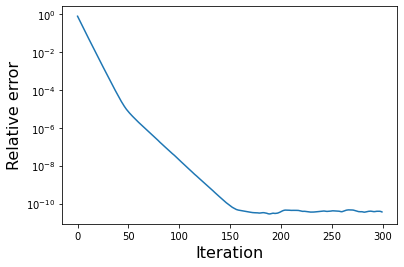

In [36]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.semilogy(rel_error_avg)

plt.xlabel("Iteration", fontsize=16)
plt.ylabel("Relative error", fontsize=16)